# Plots

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from imageio import imread
from wordcloud import WordCloud
import time

gridc = (1., 1., 1)
plt.rcParams['grid.color'] = gridc
plt.rcParams["axes.edgecolor"] = (0.898, 0.925, 0.965, 1)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
sns.set(style='darkgrid', context='talk', palette='colorblind')

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>div#site { height: 100% !important; }</style>"))

In [2]:
data_path = '../data/'
image_path = '../images/'

venue_short = 'neurips2022'
# date = time.strftime("%Y%m%d")
date = '20221105'
df = pd.read_csv(f'{data_path}{venue_short}_{date}.csv')

# get average rating for each paper from ratings column
df['ratings_avg'] = df['ratings'].apply(lambda x: np.mean(eval(x)))
df['ratings_std'] = df['ratings'].apply(lambda x: np.std(eval(x)))
df['confidence_avg'] = df['confidences'].apply(lambda x: np.mean(eval(x)))
df['confidence_std'] = df['confidences'].apply(lambda x: np.std(eval(x)))

### Keywords

In [3]:
# Get list
df['keywords'] = df['keywords'].apply(eval)

data = df['keywords']
keywords = {}
for kw in data:
    kw = [_k.lower().strip() for _k in kw]
    for _k in kw:
        if _k in keywords.keys():
            keywords[_k] += 1
        else:
            keywords[_k] = 1
# sort values
keywords = {k: v for k, v in sorted(keywords.items(), key=lambda item: item[1])[::-1]}
keywords = pd.Series(keywords).sort_values(ascending=True)
# sort keyword

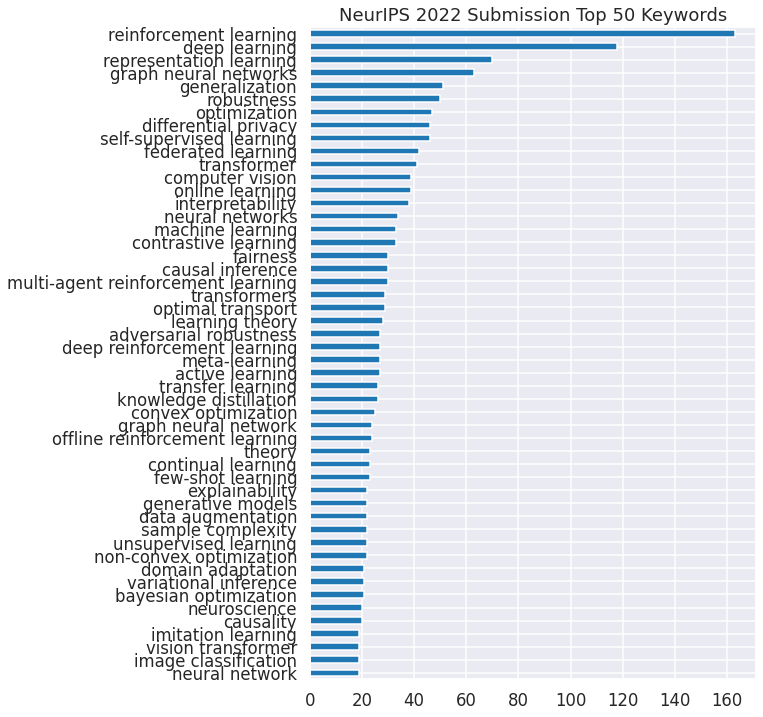

In [4]:
keywords.iloc[-50:].plot.barh(figsize=(8, 12), title='NeurIPS 2022 Submission Top 50 Keywords', color='tab:blue')
plt.savefig(f'{image_path}top50_keywords.png', bbox_inches='tight', dpi=300)

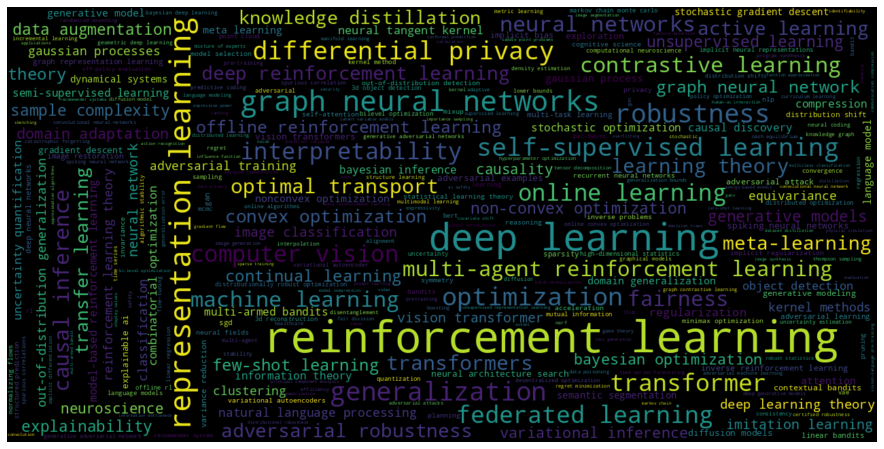

In [5]:
wc = WordCloud(background_color="black", max_words=300, max_font_size=64, 
               width=1280, height=640, random_state=0)
wc.generate_from_frequencies(keywords.to_dict())
fig = plt.figure(figsize=(16, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig(f'{image_path}wordcloud.png', bbox_inches='tight', dpi=200)

/tmp/ipykernel_59971/509802335.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  logo = imread('../assets/NeurIPS-mask.png')


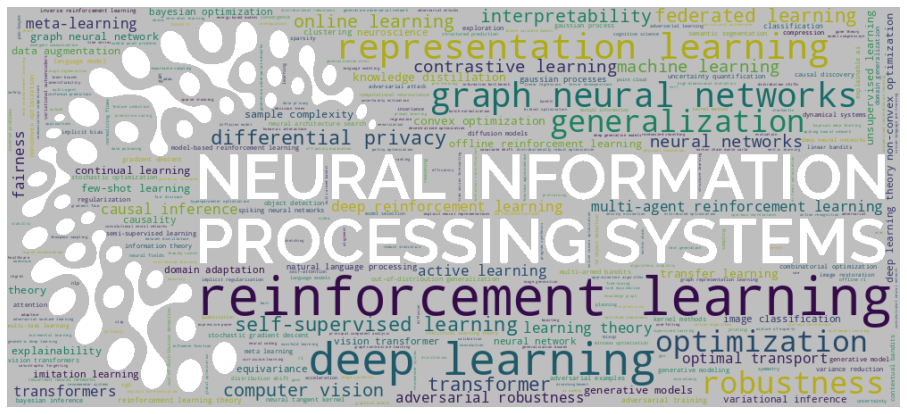

In [6]:
logo = imread('../assets/NeurIPS-mask.png')

wc = WordCloud(background_color="white", max_words=300, max_font_size=64, 
               width=1280, height=640, random_state=0, mask=logo, contour_color='black')
wc.generate_from_frequencies(keywords.to_dict())
fig = plt.figure(figsize=(16, 8))
plt.imshow(logo)
plt.imshow(wc, interpolation="bilinear", alpha=.75)
plt.axis("off")
plt.savefig(f'{image_path}wordcloud_nice.png', bbox_inches='tight', dpi=300)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


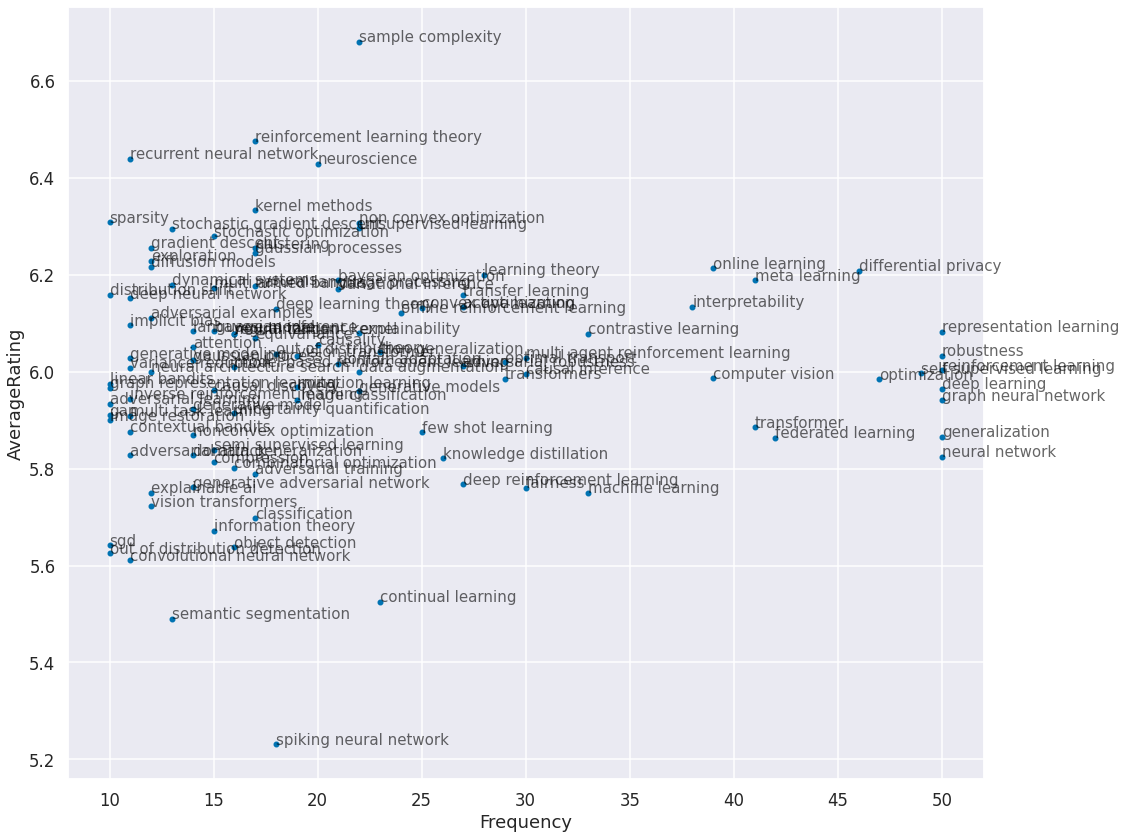

In [7]:
data = {}
for keywords, rating in zip(df.keywords, df.ratings_avg):
    if (isinstance(keywords, float) and np.isnan(keywords)) or np.isnan(rating):
        continue
    for keyword in keywords:
        data.setdefault(keyword.lower().replace('-', ' ').replace('networks', 'network').strip(), []).append(rating)

t = pd.DataFrame({
    'Frequency': [min(len(v), 50) for v in data.values()], # clip to 50
    'AverageRating': [np.mean(v) for v in data.values()],
    'Keyword': list(data.keys())
}).query('Frequency>9')
t.plot.scatter(x='Frequency', y='AverageRating', figsize=(16, 12))

for i in range(len(t)):
     plt.text(t.Frequency.iloc[i], t.AverageRating.iloc[i], t.Keyword.iloc[i], 
              horizontalalignment='left', 
              size='small', color='black', alpha=0.6)

plt.tight_layout()
plt.savefig(f'{image_path}keyword_rating.png', bbox_inches='tight', dpi=200)

### Statistics

In [8]:
# all decisions
data = df['ratings_avg']
rating_avgs = np.array(data).transpose()
# exclude nan
print("\n> Total submissions (including the withdraw): {}".format(len(data)))
rating_avgs = rating_avgs[~np.isnan(rating_avgs)]
print(f"  Avg: {rating_avgs.mean():.2f} ± {rating_avgs.std():.2f}")

print("\n> Accepted submissions: {}".format(len(df.query('decision=="Accept"'))))
data = df.query('decision=="Accept"')['ratings_avg']
accept_avgs = np.array(data).transpose()
print(f"  Avg: {accept_avgs.mean():.2f} ± {accept_avgs.std():.2f}")

print("\n> Rejected submissions with public release: {}".format(len(df.query('decision!="Accept"'))))
data = df.query('decision!="Accept"')['ratings_avg']
reject_avgs = np.array(data).transpose()
print(f"  Avg: {reject_avgs.mean():.2f} ± {reject_avgs.std():.2f}")



> Total submissions (including the withdraw): 2824
  Avg: 6.00 ± 0.72

> Accepted submissions: 2671
  Avg: 6.06 ± 0.64

> Rejected submissions with public release: 153
  Avg: 4.84 ± 0.99


2824
All papers: 153


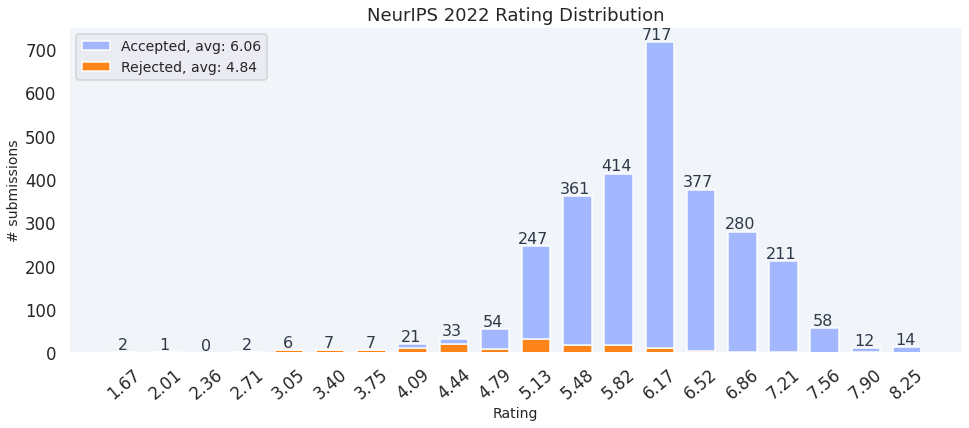

In [9]:
data = df['ratings_avg']
# data = df[df['withdraw'] == 0]['ratings_avg']
rating_avgs = np.array(data)
rating_avgs = rating_avgs[~np.isnan(rating_avgs)]
_min, _max = rating_avgs.min(), rating_avgs.max()
# print(_min, _max)


width = 0.24
fig = plt.figure(figsize=[16, 6], frameon=False)

ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor((0.898, 0.925, 0.965, 0.5))
ax.spines['left'].set_color('w')
ax.spines['bottom'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['top'].set_color('w')

# all submissions
hist, bin_edges = np.histogram(rating_avgs, bins=20, range=(_min, _max))
# ax.bar(np.linspace(_min, _max, len(hist)), hist, width=width, alpha=0.95, 
#        color='#789BFF', capsize=4)
print(sum(hist))
for i, v in zip(np.linspace(_min, _max, len(hist)), hist):
    ax.text(i - 0.05 * len(str(v)), v + 6.0, str(v), color='#2f3a49', fontsize=16)

# rejected submissions
hist_reject, _ = np.histogram(reject_avgs, bins=20, range=(_min, _max))
print(f"All papers: {sum(hist_reject)}")
ax.bar(np.linspace(_min, _max, len(hist)), hist_reject, width=width, alpha=0.95, 
       color='tab:orange', capsize=4, label='Rejected, avg: {:.2f}'.format(reject_avgs.mean()))

# accept
hist_poster, _ = np.histogram(accept_avgs, bins=20, range=(_min, _max))
ax.bar(np.linspace(_min, _max, len(hist)), hist_poster, bottom=hist_reject, width=width, alpha=0.95, 
       color='#A0B5FF', capsize=4, label='Accepted, avg: {:.2f}'.format(accept_avgs.mean()))

# plt.ylim(0, 450)
plt.xticks(ticks=np.linspace(_min, _max, len(hist)), 
           rotation=40, 
           labels=[f"{d:.2f}" for d in np.linspace(_min, _max, len(hist))])
ax.set_ylabel(r"# submissions", fontsize=14)
ax.set_xlabel("Rating", fontsize=14)
ax.set_axisbelow(True)
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc=2, fontsize=14)
plt.title('NeurIPS 2022 Rating Distribution')
# make figure white
plt.savefig(f'{image_path}stats_barplot_{date}.png')

In [10]:
def flatten(l):
    return [item for sublist in l for item in sublist]

# Convert to list of int via eval
review_lengths = flatten(df['review_lengths'].apply(lambda x: eval(x)).tolist())
ratings = flatten(df['ratings'].apply(lambda x: eval(x)).tolist())
confidences = flatten(df['confidences'].apply(lambda x: eval(x)).tolist())

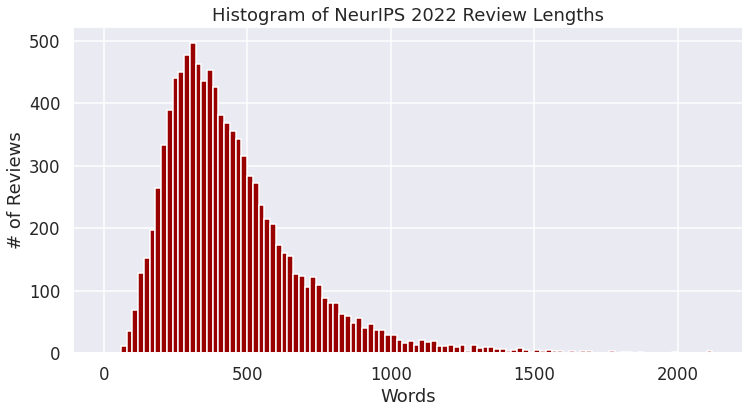

In [11]:
# Plot histograms of review len
fig = plt.figure(figsize=(12, 6))
plt.title('Histogram of NeurIPS 2022 Review Lengths')


# Review length hist (remove the 10 shortest/longest reviews)
interval = 20
all_review_len_sorted_clip = sorted(review_lengths)[10:-10]
plt.hist(all_review_len_sorted_clip, bins=[v*interval for v in list(
    np.array(range(np.max(all_review_len_sorted_clip)//interval)))],
    color='#990000')
plt.xlabel('Words')
plt.ylabel('# of Reviews')
plt.savefig(f'{image_path}review_length_hist_{date}.png')

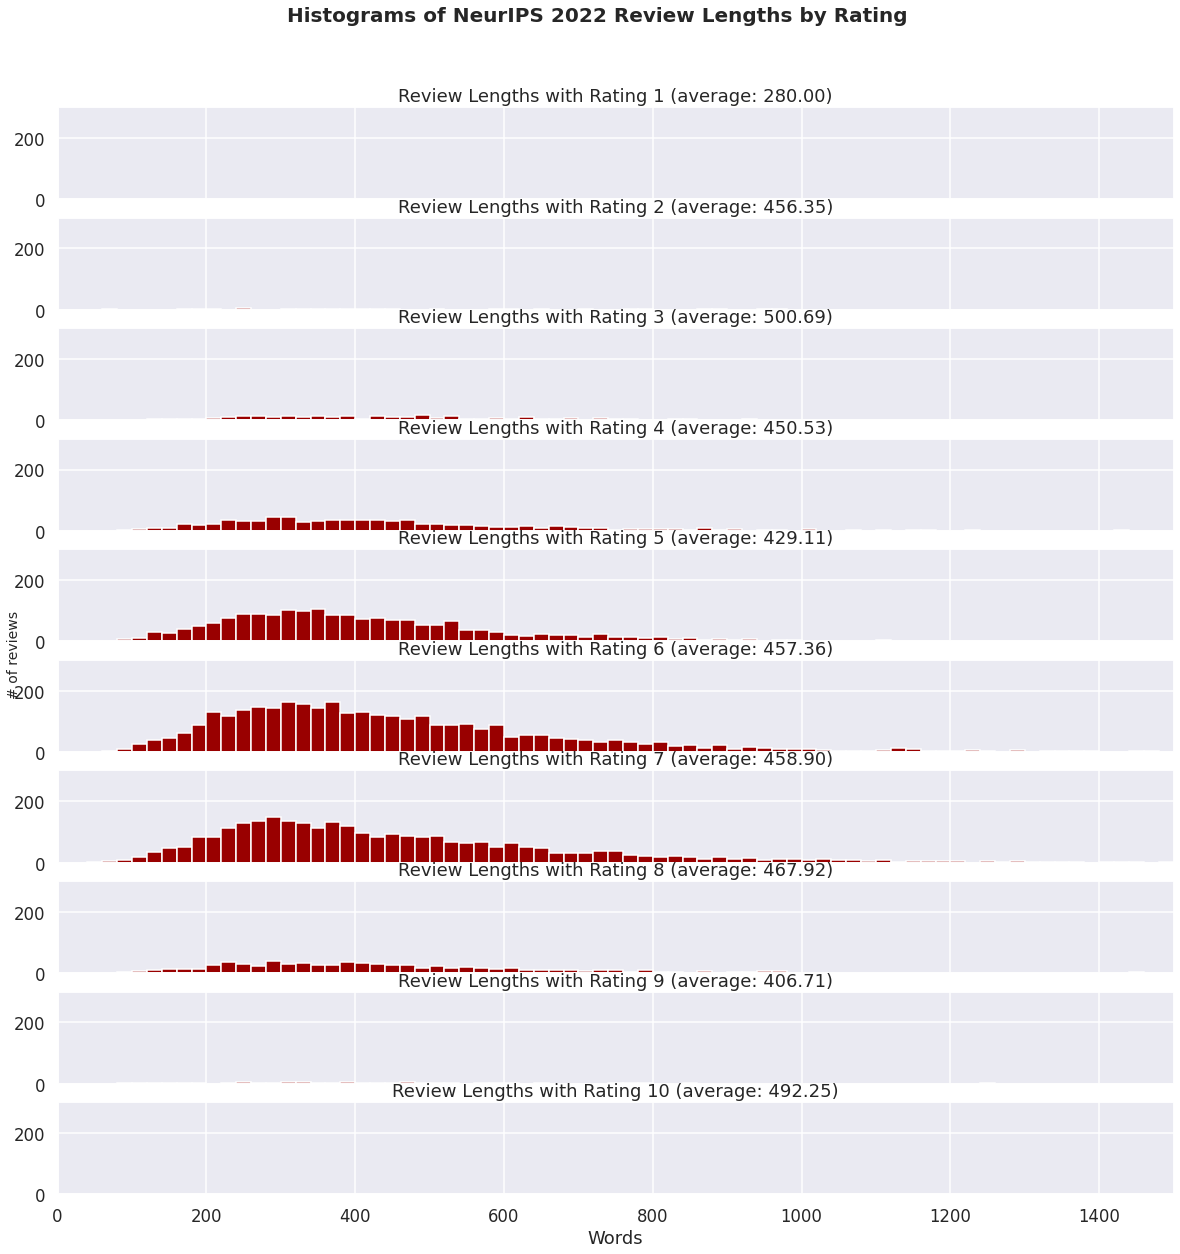

In [38]:
unique_ratings = np.unique(ratings)
bins = [v*interval for v in list(np.array(range(np.max(review_lengths)//interval)))]
gs = gridspec.GridSpec(len(unique_ratings), 1) 
fig = plt.figure(figsize=(20, 20))
for i, unique_rating in enumerate(unique_ratings):
    plt.subplot(gs[i])
    # Plot histograms of review len
    
    # Review length hist
    all_review_len_rating = []
    for j, r in enumerate(ratings):
        if r == unique_rating:
            all_review_len_rating.append(review_lengths[j])
            
    plt.title('Review Lengths with Rating {} (average: {:.2f})'.format(
        unique_rating, np.mean(all_review_len_rating)))
    
    plt.hist(all_review_len_rating, bins=bins, color='#990000')
    if i == len(unique_ratings)-1:
        plt.xlabel('Words')
    else:
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off    
    plt.ylim(0, 300)
    plt.xlim(0, 1500)     
    # plt.ylabel('# of reviews')   
# single y label for the whole figure
fig.text(0.09, 0.5, '# of reviews', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Histograms of NeurIPS 2022 Review Lengths by Rating', fontsize=20, fontweight='bold', y=0.95) # or plt.suptitle('Main title')  
# fig.tight_layout() 
plt.savefig(f'{image_path}review_length_by_rating_{date}.png')

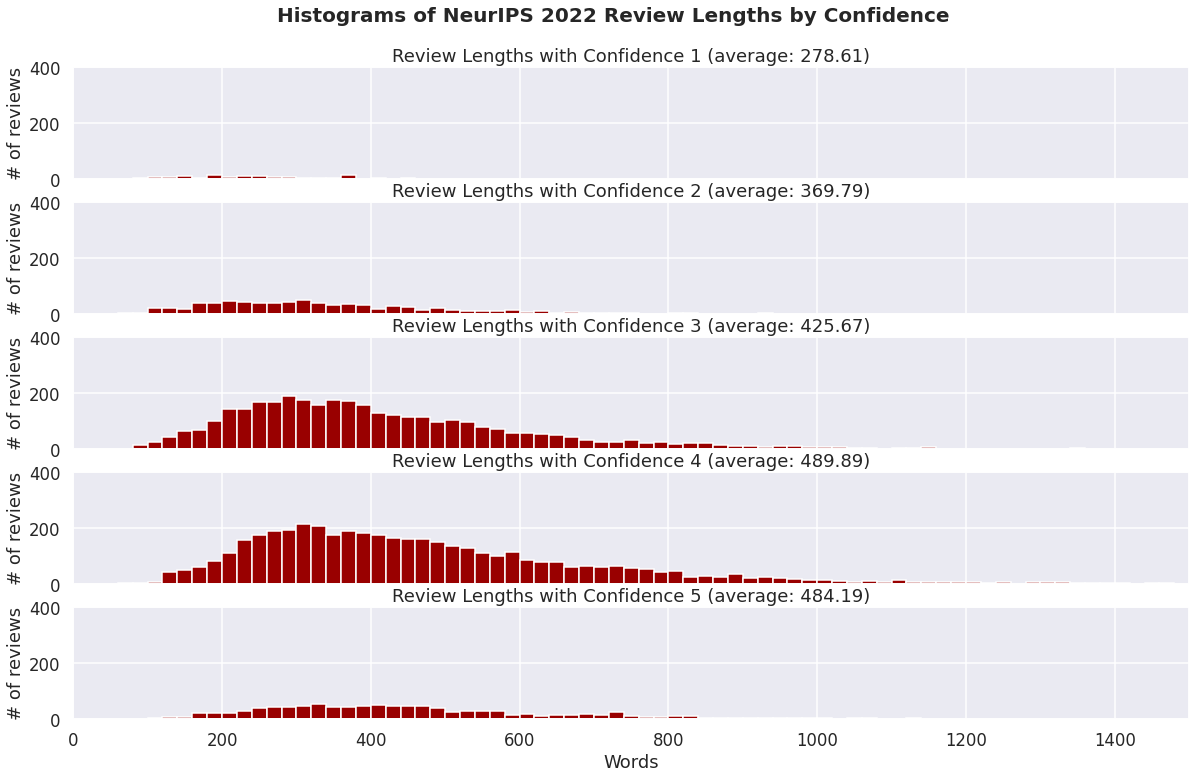

In [30]:
unique_confidences = np.unique(confidences)
bins = [v*interval for v in list(np.array(range(np.max(review_lengths)//interval)))]
gs = gridspec.GridSpec(len(unique_confidences), 1) 
fig = plt.figure(figsize=(20, 12))
for i, unique_rating in enumerate(unique_confidences):
    plt.subplot(gs[i])
    # Plot histograms of review len
    
    # Review length hist
    all_review_len_rating = []
    for j, r in enumerate(confidences):
        if r == unique_rating:
            all_review_len_rating.append(review_lengths[j])
            
    plt.title('Review Lengths with Confidence {} (average: {:.2f})'.format(
        unique_rating, np.mean(all_review_len_rating)))
    
    plt.hist(all_review_len_rating, bins=bins, color='#990000')
    if i == len(unique_confidences)-1:
        plt.xlabel('Words')
    else:
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off    
    plt.ylim(0, 400)
    plt.xlim(0, 1500)     
    plt.ylabel('# of reviews')   
fig.suptitle('Histograms of NeurIPS 2022 Review Lengths by Confidence', fontsize=20, fontweight='bold', y=0.95) # or plt.suptitle('Main title')   
plt.savefig(f'{image_path}review_length_by_confidence_{date}.png')

## PDF data

In [31]:
pdf_data = pd.read_hdf(f'{data_path}{venue_short}_pdf_data_{date}.h5')
df_full = df.merge(pdf_data, on='id', how='left')
# eliminate nan data
df_full = df_full.dropna(subset=['ratings_avg'])
# drop num pages = 0 (only one paper had a problem in crawling pages)
df_full = df_full[df_full['num_pages'] != 0]
df_full.head()

,id,title,keywords,ratings,confidences,withdraw,review_lengths,decision,ratings_avg,ratings_std,confidence_avg,confidence_std,text,num_characters,num_pages,file_size
0,09QFnDWPF8,Statistical Learning and Inverse Problems: A S...,"[Statistical Learning, Inverse Problems, Stoch...","[8, 5, 7]","[3, 3, 3]",0,"[875, 649, 214]",Accept,6.666667,1.247219,3.000000,0.000000,Statistical Learning and Inverse Problems:\nA ...,49331,18,508255
1,pnSyqRXx73,Efficiency Ordering of Stochastic Gradient Des...,"[Stochastic Gradient Descent, Asymptotic Analy...","[5, 6, 7, 7]","[3, 3, 4, 4]",0,"[1280, 118, 287, 777]",Accept,6.250000,0.829156,3.500000,0.500000,Efficiency Ordering of Stochastic Gradient Des...,53623,14,693351
2,EqJ5_hZSqgy,Self-Aware Personalized Federated Learning,"[Federared Learning, Personalization]","[7, 7, 3]","[3, 3, 3]",0,"[209, 303, 221]",Accept,5.666667,1.885618,3.000000,0.000000,Self-Aware Personalized Federated Learning\nHu...,83728,27,1176929
3,xnI37HyfoP,Nonnegative Tensor Completion via Integer Opti...,"[tensor completion, machine learning]","[7, 6, 6]","[4, 3, 4]",0,"[445, 269, 1083]",Accept,6.333333,0.471405,3.666667,0.471405,Nonnegative Tensor Completion\nvia Integer Opt...,42499,15,380680
4,OoNmOfYVhEU,TPU-KNN: K Nearest Neighbor Search at Peak FLOP/s,"[TPU, K-nearest neighbor search, Approximate n...","[6, 5, 6, 6]","[4, 5, 4, 4]",0,"[162, 204, 446, 233]",Accept,5.750000,0.433013,4.250000,0.433013,TPU-KNN\nK Nearest Neighbor Search at Peak FLO...,48782,18,462415


In [32]:
# Plot
def plot_correlation(df, title='Correlation Plot', length=20, width=20, save=False):
    '''
    Plot correlation map of input and outputs
    Display only the lower half that matters (since it is a symmetric matrix)
    '''
    plt.figure(figsize=(length, width))
    corr = df.corr()
    corr = corr.dropna(axis=1, how='all') # drop NA correlations on rows
    corr = corr.dropna(axis=0, how='all') # drop NA correlations on columns
    mask = np.triu(np.ones_like(corr, dtype=np.bool)) # generate a mask for the upper triangle
    cmap = "RdBu_r" # generate a custom diverging colormap

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(
        corr,
        mask=mask,
        cmap=cmap,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
        annot=True,
        fmt=".2f"
    )
    plt.title(title, fontsize=20, fontweight='bold')
    if save: plt.savefig('Correlation Plot.pdf', bbox_inches='tight')

    # Return dataframe with explanatory variables only
    return df[corr.columns]

In [33]:
df_full['confidence_avg'] = df_full['confidences'].apply(lambda x: np.mean(eval(x)))
df_full['review_lengths_avg'] = df_full['review_lengths'].apply(lambda x: np.mean(eval(x)))

df_values = df_full[['ratings_avg', 'num_pages', 'file_size', 'confidence_avg', 'review_lengths_avg']]

/tmp/ipykernel_59971/1762992798.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool)) # generate a mask for the upper triangle


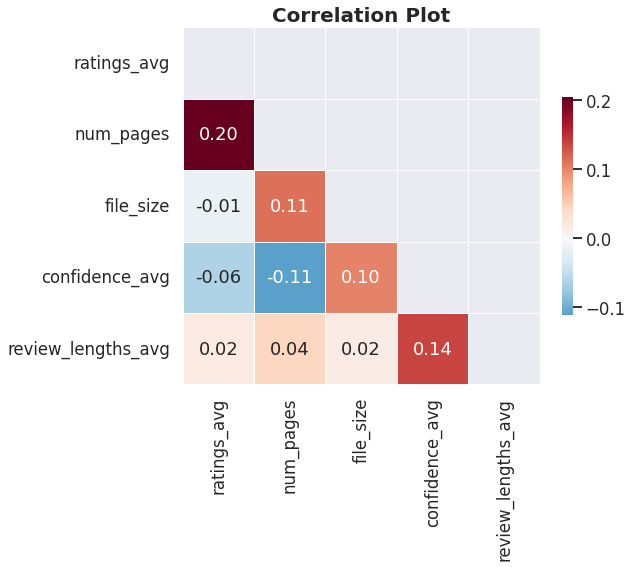

In [34]:
_ = plot_correlation(df_values,  length=8, width=8, save=False)

Average number of pages: 21.65 


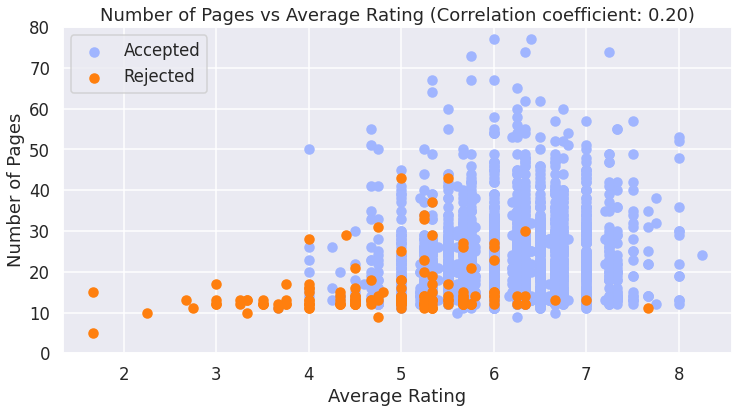

In [18]:
# Plot number of pages vs average ratings
fig = plt.figure(figsize=(12, 6))
plt.title(r"Number of Pages vs Average Rating (Correlation coefficient: {:.2f})".format(np.corrcoef(df_full['ratings_avg'], df_full['num_pages'] / (1024**2))[0, 1]))

# plt.scatter(df_full['ratings_avg'], df_full['num_pages'], color='#990000')
# scatter of accepted
plt.scatter(df_full[df_full['decision'] == 'Accept']['ratings_avg'], df_full[df_full['decision'] == 'Accept']['num_pages'], color='#A0B5FF', label='Accepted')
# scatter of rejected
plt.scatter(df_full[df_full['decision'] != 'Accept']['ratings_avg'], df_full[df_full['decision'] != 'Accept']['num_pages'], color='tab:orange', label='Rejected')
plt.xlabel('Average Rating')
plt.ylabel('Number of Pages')
plt.legend()
# set limit
plt.ylim(0, 80) # cut paper with more than 50 pages

print("Average number of pages: {:.2f} ".format(df_full['num_pages'].mean()))
plt.savefig(f'{image_path}num_pages_vs_ratings_{date}.png')

In [19]:
df_full_ = pd.read_hdf(f'{data_path}{venue_short}_data_full_{date}.h5')

In [20]:
print("Heaviest paper: ", df_full[df_full['file_size'] == df_full['file_size'].max()]['title'].values[0], "\nSize (MB): {:.2f}".format(df_full['file_size'].max() / (1024**2)))
print("Paper with most pages: ", df_full[df_full['num_pages'] == df_full['num_pages'].max()]['title'].values[0], "\nPages: ", df_full['num_pages'].max())
most_replies = df_full_[df_full_[48].notnull()]
print("Paper with longest rebuttal: ", most_replies['content.title'].values[0], "\nReplies: ", 48)
rejected = df_full[(df_full['decision'] != 'Accept')]
highest_rejected = rejected[rejected['ratings_avg'] == rejected['ratings_avg'].max()]
print("Highest rated rejected paper: ", highest_rejected['title'].values[0], "\nAverage rating: {:.2f}".format(highest_rejected['ratings_avg'].values[0]))


Heaviest paper:  Mining Multi-Label Samples from Single Positive Labels 
Size (MB): 49.70
Paper with most pages:  FasterRisk: Fast and Accurate Interpretable Risk Scores 
Pages:  83
Paper with longest rebuttal:  RankFeat: Rank-1 Feature Removal for Out-of-distribution Detection 
Replies:  48
Highest rated rejected paper:  Undersampling is a Minimax Optimal Robustness Intervention in Nonparametric Classification 
Average rating: 7.67


In [21]:
# Get authors from papers
def get_authors():
    authors = []
    acceptances = []
    for i in range(len(df)):
        authors.append(df_full_['content.authors'][i])
        df['decision']
        acceptances.append(df['decision'][i])
    return authors, acceptances

authors, acceptances = get_authors()
# build a dictionary of all authors with their acceptance status and rejection status and first author
authors_dict = {}
for i in range(len(authors)):
    for author in authors[i]:
        if author not in authors_dict:
            authors_dict[author] = {'accept': 0, 'reject': 0, 'first_author_accept': 0}
        if acceptances[i] == 'Accept':
            authors_dict[author]['accept'] += 1
            if authors[i][0] == author:
                authors_dict[author]['first_author_accept'] += 1
        else:
            authors_dict[author]['reject'] += 1


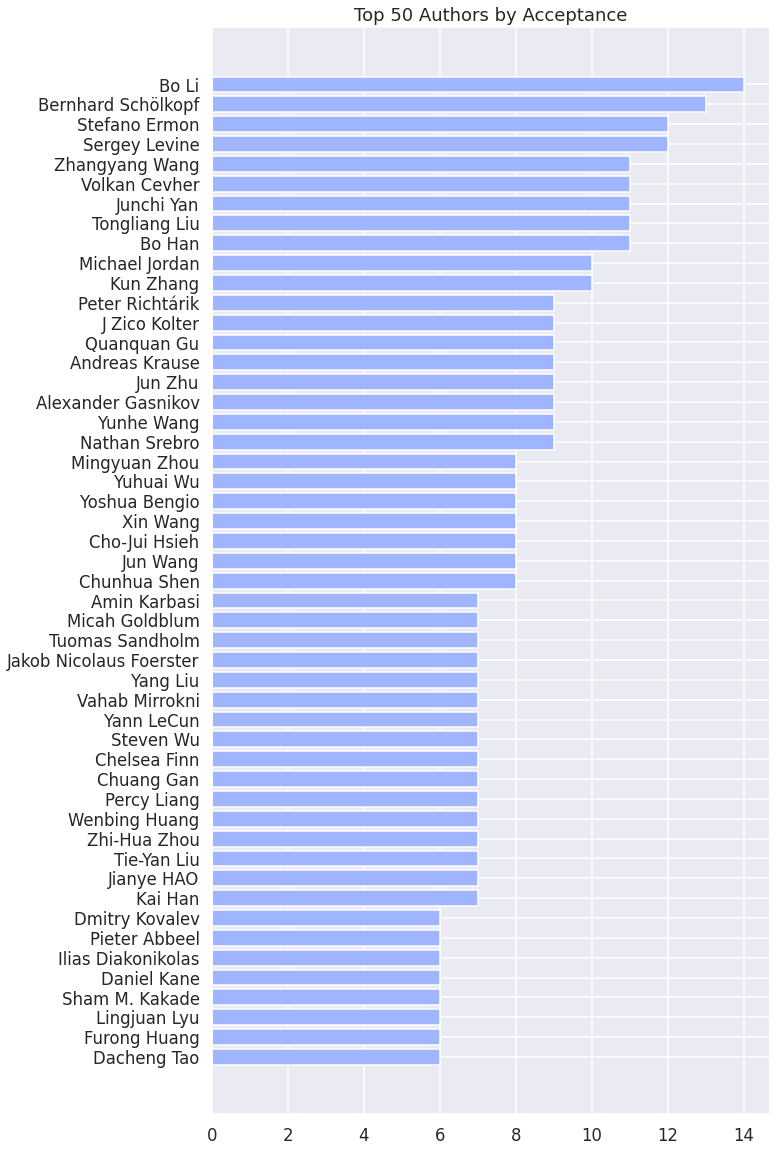

In [36]:
# Get top 50 authors by accept
top_authors = sorted(authors_dict.items(), key=lambda x: x[1]['accept'], reverse=True)[:50]

# Plot vertically reversed bar chart
fig = plt.figure(figsize=(10, 20))
plt.title("Top 50 Authors by Acceptance")
plt.barh([author[0] for author in top_authors], [author[1]['accept'] for author in top_authors], color='#A0B5FF')
plt.gca().invert_yaxis()
plt.savefig(f'{image_path}top_authors.png', bbox_inches='tight')